# Data Scientist Professional Practical Exam Submission

**Predicting whether a recipe can bring "High" traffic to Tasty Byte's website or not.**


# 1) Data Validation
#### Dataset contains 947 rows and 8 columns , there isn't any duplicated rows.<br> PreProcessing is the key component of a successful ML project , that's why during this first phase of preprocessing , I gave a lot of importance to details and i validated every column. <br> Here is a summary of my work in this section (you can find more details in the cells below) :<br> <br> -Only "serving" has a corrupted column dtype (ALL the other columns have a valid type) , so for "serving" (no missing values) , i extracted the important informations from its values(exp : "4 as a snack" we only need "4" , the same for "6 as a snack") and then I transformed it into a numerical feature (dtype = int) <br> -In the "high traffic" column , only the High traffic recipes have been labeled , so I replaced the missing values with "Low" <br> -"recipe" doesn't present any missing values , it is the unique identifier of a recipe that's why i choose to use it as the index <br> -For the missing values , after some analysis , i concluded that if one record contain at least a missing value in one of its columns then it is going to contain missing values in the "calories , carbohydrate , sugar , protein" columns all at the same time and those records represent only 5.5% of our dataset that's why I decided to drop those records and now we don't have any missing value in any column of any reocrd <br>-"category" has a non-valid group : "Chicken Breast" , so i replaced it with "Chicken" and now it contains 10 possible groups


#### Importing all the essential packages

In [3]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind , iqr
from sklearn.model_selection import train_test_split , GridSearchCV , StratifiedKFold
from category_encoders import CountEncoder
from sklearn.preprocessing import PowerTransformer,StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , confusion_matrix , precision_score

#### Load the Recipe traffic dataset

In [4]:
data = pd.read_csv('./recipe_site_traffic_2212.csv')
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


#### Dataset contain 947 rows and 8 columns

In [5]:
data.shape

(947, 8)

#### Dataset doesn't contain any duplicated rows

In [6]:
data = data.drop_duplicates()
data.shape

(947, 8)

#### We can notice that only the "servings" column type is corrupted. 

In [7]:
data.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

In [8]:
data['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

#### Extracted the useful informations in the current servings column and then converted it into a numerical type

In [9]:
data['servings'] = data['servings'].str[0]
data['servings'].unique()

array(['6', '4', '1', '2'], dtype=object)

In [10]:
data['servings'] = data['servings'].astype('int')

#### The recipe column is the unique identifier and doesn't present any missing values so it should be used as the index 

In [11]:
print("The number of missing values in the recipe column is :",data['recipe'].isna().sum())
data = data.set_index('recipe')

The number of missing values in the recipe column is : 0


#### Only the High recipes have been labeled , all the nan values are going to be filled with "Low"

In [12]:
data['high_traffic'] = data['high_traffic'].fillna('Low')
data['high_traffic'].value_counts()

High    574
Low     373
Name: high_traffic, dtype: int64

#### Only the "calories , carbohydrate , sugar , protein" columns contain missing values with an equal percentage of 5.5% from their whole values => Since the rate of missing values is the same between all of them so maybe there are 5% of our whole records that bring the missing values

<AxesSubplot: >

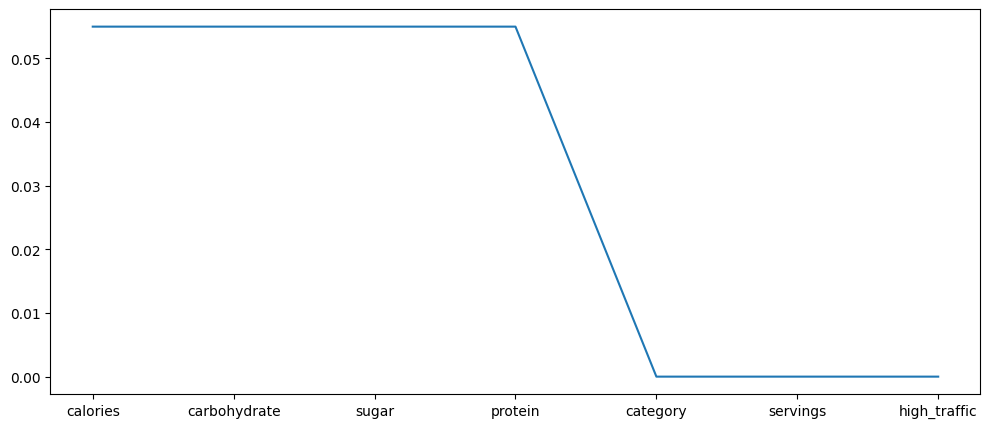

In [13]:
feature_nanvalues_rate = (data.isna().sum(axis=0)/data.shape[0]).round(3)
feature_nanvalues_rate.plot(figsize=(12,5))

#### The light color shows the presence of a missing value =>When we have a light value in a column it's going to be a part of a whole continuos ligh line => ALl the missing values in the "calories , carbohydrate , sugar , protein" columns are coming from the same records

<AxesSubplot: ylabel='recipe'>

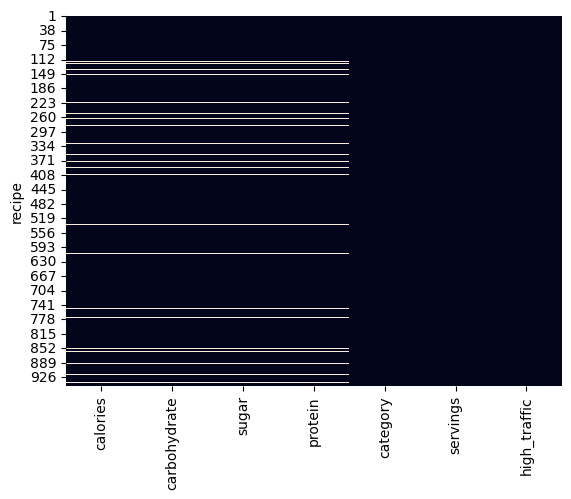

In [14]:
sns.heatmap(data.isna(),cbar=False)

#### There is only 5% of our records that present a missing value and since we concluded that if a record has a missing value in one column , he is going to have missing values in "calories , carbohydrate , sugar , protein" columns at the same time <br> ==> I'm going to delete those 5% reocrds 

<AxesSubplot: title={'center': 'Distribution of records'}>

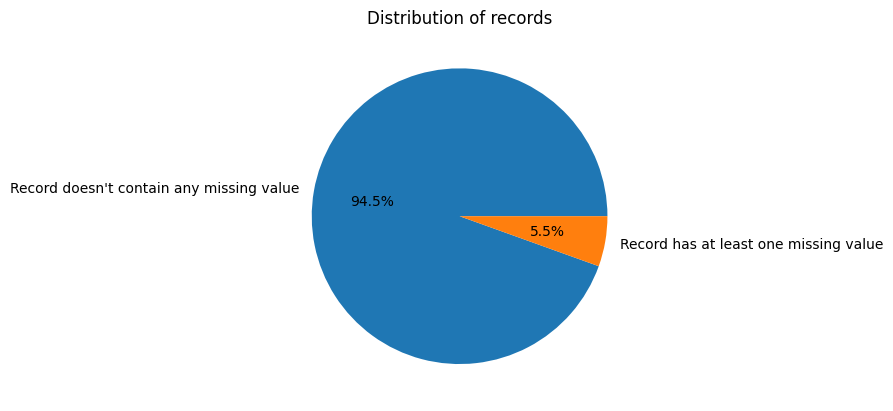

In [15]:
data.isna().any(axis=1).value_counts().plot.pie(autopct='%1.1f%%',labels=['Record doesn\'t contain any missing value','Record has at least one missing value'],title='Distribution of records')

In [16]:
data = data.dropna()
data.shape

(895, 7)

#### category column is supposed to have only 10 different types => We have 11 <br>'Chicken Breast' must be categorized as 'Chicken'

In [17]:
print("The number of different categories is :",data['category'].nunique())
data['category'].unique()

The number of different categories is : 11


array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Pork', 'Chicken', 'Vegetable',
       'Meat', 'Dessert'], dtype=object)

In [18]:
data['category'] = data['category'].replace('Chicken Breast','Chicken')

#### Double checking that the types are valid

In [19]:
data.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int64
high_traffic     object
dtype: object

# 2) Exploratory Analysis


#### This pointplot shows that the most reccuring group in the 'category' column is "Chicken".<br> So we can expect that the most accurate predictions are going to be related to the chicken group.

Text(0, 0.5, 'Count')

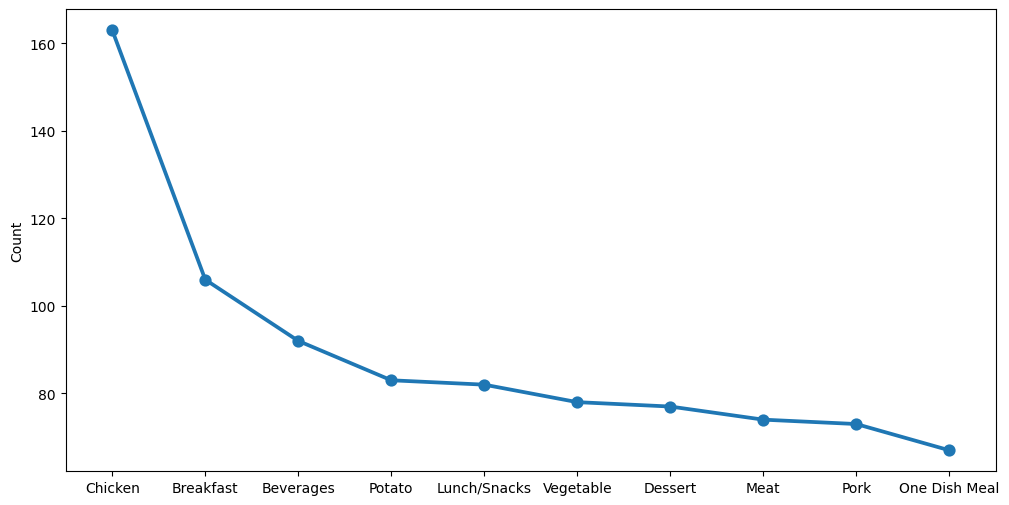

In [20]:
plt.figure(figsize=(12,6))
sns.pointplot(data['category'].value_counts())
plt.ylabel("Count")

#### This is the distribution of values in the "high_traffic" column. We can notice that the "High" recipes ,with almost 60% , present the majority of our dataset thus making it an unbalanced dataset.

<AxesSubplot: ylabel='high_traffic'>

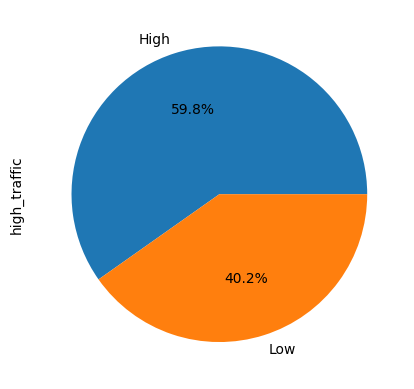

In [21]:
data['high_traffic'].value_counts().plot.pie(autopct='%1.1f%%')

#### This countplot shows that the most reccuring serving is 4.<br> So we can expect that the most accurate predictions are going to be related to the recipes having serving = 4.

<AxesSubplot: xlabel='servings', ylabel='count'>

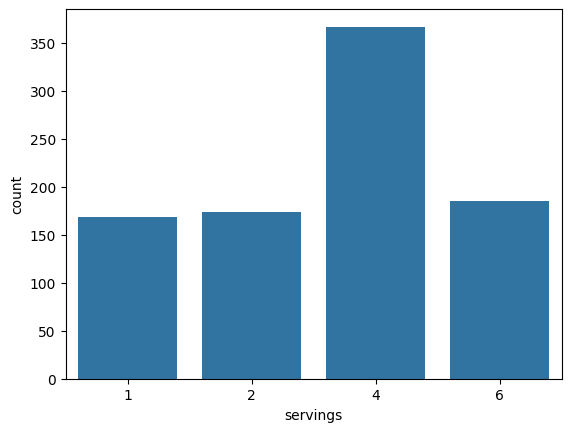

In [22]:
sns.countplot(x='servings',data=data)

#### The numerical features present right skeweed distribution , we can notice the presence of some outliers which can corrupt our analysis and slow down our training , we will have to deal with them and work on scaling and normalizing our continuos features.

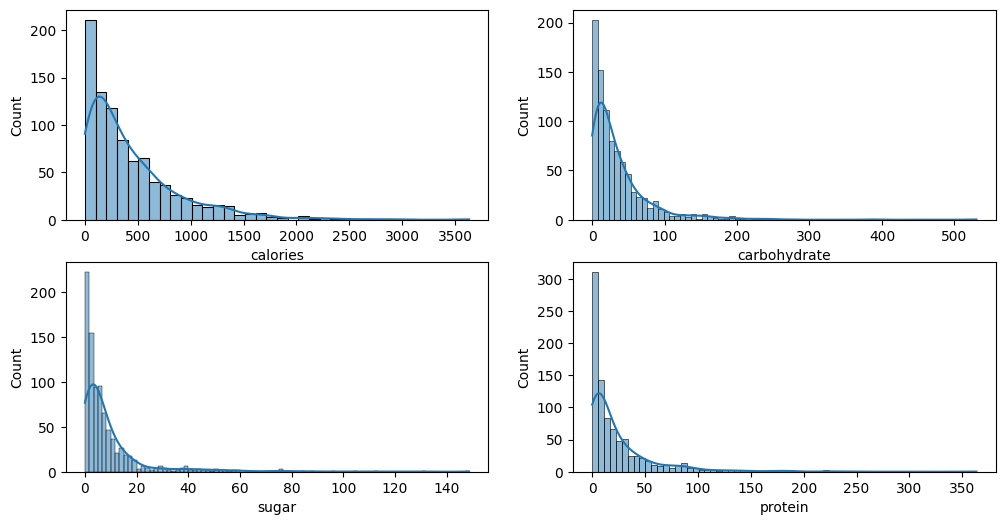

In [23]:
plt.figure(figsize=(12,6))
float_features = data.select_dtypes(include='float').columns
for i,col in enumerate (float_features):
    plt.subplot(2,2,i+1)
    sns.histplot(x=col,data=data,kde=True)

#### Those graphs show us the relationship between each feature and the high_traffic column. <br> We can notice that for each column, the two distributions has almost the same shape without any deviation , this can tell us that those columns by themselves won't be enough to seperate between "High" and "Low" recipes.<br> I'm going to try to reject this null hypothesis in the next cell.

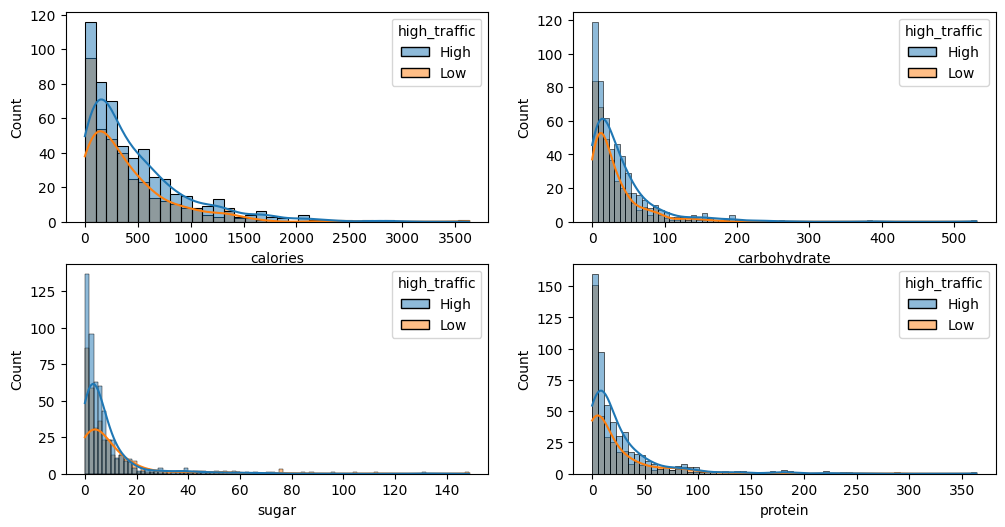

In [24]:
plt.figure(figsize=(12,6))
float_features = data.select_dtypes(include='float').columns
for i,col in enumerate (float_features):
    plt.subplot(2,2,i+1)
    sns.histplot(x=col,data=data,kde=True,hue='high_traffic')

H0 (null hypothesis) : our continuos features can't seperate between the high_traffic recipes.<br>
After using ttest and pvalue , we couldn't reject it which goes with what we did already expect since the distributions are the same then their means are going to be very similar.

In [25]:
high_traffic_data = data[data['high_traffic'] == 'High']
low_traffic_data = data[data['high_traffic'] == 'Low']
high_traffic_data = high_traffic_data.sample(n=low_traffic_data.shape[0])
alpha = 0.02
print('Can we reject H0 with at least one of our continuos features :')
for col in float_features:
    _ , p = ttest_ind(high_traffic_data[col],low_traffic_data[col])
    if p < alpha :
        print(f'{col : <20}H0 rejected')
    else :
        print(f'{col : <20}Can\'t reject H0')

Can we reject H0 with at least one of our continuos features :
calories            Can't reject H0
carbohydrate        Can't reject H0
sugar               Can't reject H0
protein             Can't reject H0


#### We see that the all the values are close to 0 which states that our continuos features doesn't present linear relationship between each other , all the features aren't correlated.

<AxesSubplot: >

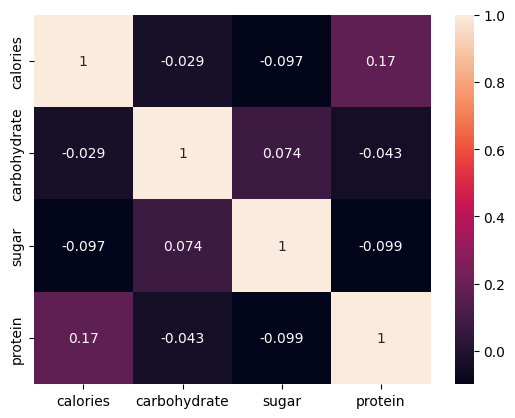

In [26]:
sns.heatmap(data[float_features].corr(),annot=True)

#### For each value of serving , we can notice that always the "High" traffic recipes are much more than the "Low" ones so normally this feature won't have a huge importance in seperating between the recipes.

<AxesSubplot: xlabel='servings', ylabel='count'>

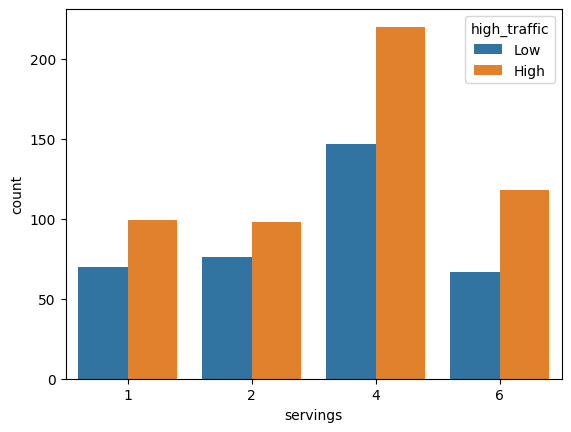

In [27]:
sns.countplot(x='servings',data=data,hue='high_traffic')

#### Finally, This is the kind of feature that we are looking for , a feature that normally will help the model to be able to seperate between our recipes since for certain groups we have the "High" count is bigger and for others the "Low" count is bigger.

<AxesSubplot: xlabel='category', ylabel='count'>

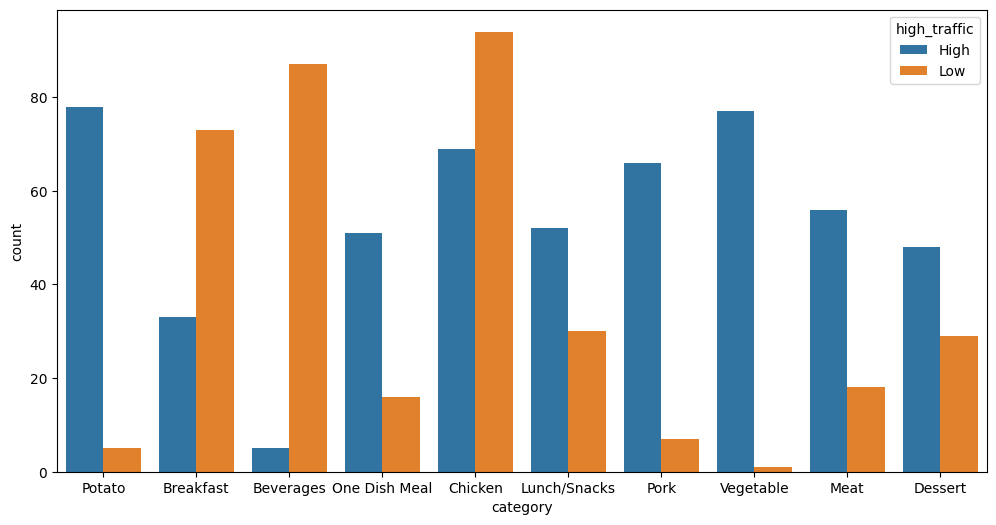

In [28]:
plt.figure(figsize=(12,6))
sns.countplot(x='category',data=data,hue='high_traffic')

#### From those boxplots , we can see that the medians and the IQR are very similar between High and Low recipes for all the continuos features . <br> However , the most important thing to notice is the presence of outliers in all those features that's why i'm going to deal with them in the next cell.

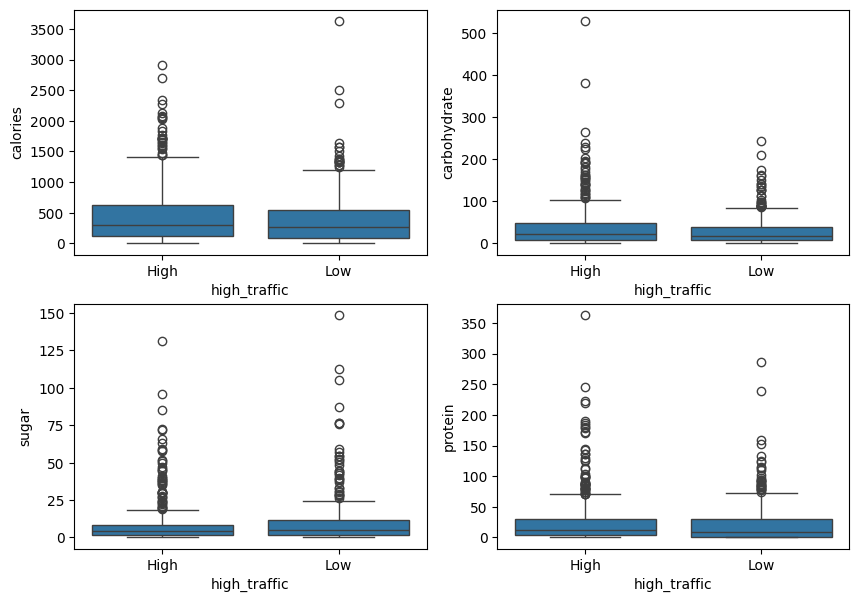

In [29]:
plt.figure(figsize=(10,7))
for i,col in enumerate (float_features):
    plt.subplot(2,2,i+1)
    sns.boxplot(x='high_traffic',y=col,data=data)

<AxesSubplot: title={'center': 'How many outliers does a record have ?'}>

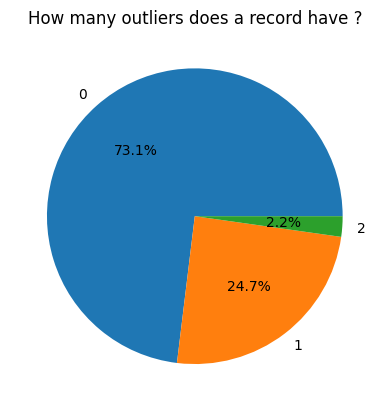

In [30]:
Q3_Q1_dict = {}
for col in float_features:
    Q1_Q3 = (data[col].quantile(.25),data[col].quantile(.75))
    Q3_Q1_dict[col] = (iqr(data[col]),Q1_Q3)

def number_outliers_in_single_record(row):
    n_outlier = 0
    for col in float_features:
        if row[col] > Q3_Q1_dict[col][1][1]+ 1.5 * Q3_Q1_dict[col][0] or row[col] <Q3_Q1_dict[col][1][0] - 1.5 * Q3_Q1_dict[col][0]:
            n_outlier += 1
    return n_outlier 
record_outliers_count = data.apply(number_outliers_in_single_record,axis=1)
record_outliers_count.value_counts().plot.pie(autopct='%1.1f%%',title="How many outliers does a record have ?")

Since the records that contain 2 outliers from possible 4 values represent 2% from our whole dataset (20 records) , i decided to drop them. <br> For the remaining records , which are going to have at most one outlier , if they present an outlier , i replaced its value with the most suitable one (if > Q3 + 1,5 * IQR => replace it with Q3 || if < Q1 - 1,5 * IQR => replace it with Q1 )

The new shape of our dataset after dropping records with 2 outliers: (875, 7)


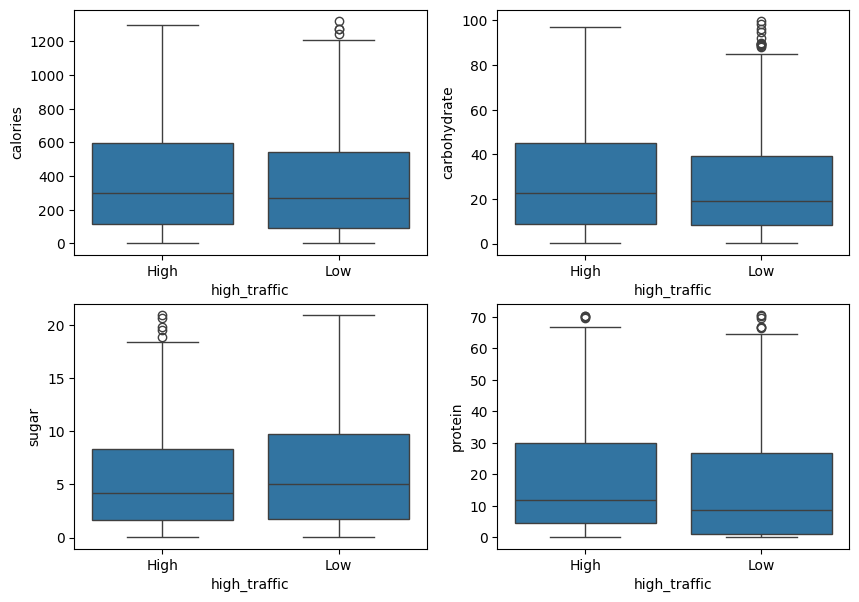

In [31]:
data = data[record_outliers_count < 2 ]
print("The new shape of our dataset after dropping records with 2 outliers:",data.shape)
for col in float_features:
    data[col] = np.where(data[col] > Q3_Q1_dict[col][1][1]+ 1.5 * Q3_Q1_dict[col][0],Q3_Q1_dict[col][1][1],data[col])
    data[col] = np.where(data[col] <Q3_Q1_dict[col][1][0] - 1.5 * Q3_Q1_dict[col][0],Q3_Q1_dict[col][1][0],data[col])
plt.figure(figsize=(10,7))
for i,col in enumerate (float_features):
    plt.subplot(2,2,i+1)
    sns.boxplot(x='high_traffic',y=col,data=data)

# 3) Model Development
#### We want to predict whether a recipe will result in a High or Low traffic => This is a binary classification problem. <br>I opted to use Logistic Regression since it is suited for binary classification tasks and at the same time it is easy to interpret.<br> As the comparaison model , I'm going to use RandomForestClassifier since it does fight against overfitting ,it is an ensemble model: bagging of different decision trees, and it scores very good results with this type of problems. <br> Before fitting the two models , i'm going to finish the preprocessing in order to have the dataset in its best possible state so that it boosts the performance.<br><br>
### Making the Dataset ready for the training of the models : 
#### -Since we want to predict whether a recipe will result in High or Low traffic => Target : high_traffic in which we are going to replace High with 1 and Low with 0<br>- It is essential that we start by splitting our dataset into train and test set so that we avoid any type of leakage <br> - For the "category" feature,I encoded its values using CountEncoder then I applied MinMaxScaler on "category" and "servings". (you can find more details about my reasoning in the description) <br> - For the continuos features , I used a pipeline composed of a PowerTransformer and a StandardScaler .


#### Extracted the target column and encoded its values , then i splitted the data into train and test sets so that i can apply the next transformations without worrying about test leakage.

In [32]:
y = data['high_traffic'].apply(lambda x : 1 if x=='High' else 0)
X = data.drop(['high_traffic'],axis=1)
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.33,random_state=1)
print("X_train shape is:" , X_train.shape)
print("y_train shape is:" , y_train.shape)
print("X_test shape is:" , X_test.shape)
print("y_test shape is:" , y_test.shape)

X_train shape is: (586, 6)
y_train shape is: (586,)
X_test shape is: (289, 6)
y_test shape is: (289,)


#### I chose to use Count Encoder in order to encode the 'category' feature: It is going to replace each category with its count in the training set (in test , we use .transform to get the values stored from the training). I didn't choose OneHotEncoding since it is going to create 10 new features and I didn't opt for LabelEncoder because it will create an order between our groups that in reality doesn't exist but the model can learn from this ordering and make false assumptions.<br> I applied the MinMaxScaler to "category" and "servings" so that the we scale them by having them  between 0 and 1 so we are sure that they have the same scale as the continuos features (We are going to work on that next). 

In [33]:
category_encoder = CountEncoder()
X_train['category'] = category_encoder.fit_transform(X_train['category'])
X_test['category'] = category_encoder.transform(X_test['category'])
categrorial_scaling = MinMaxScaler()
X_train[['category','servings']] = categrorial_scaling.fit_transform(X_train[['category','servings']])
X_test[['category','servings']] = categrorial_scaling.transform(X_test[['category','servings']])

#### For the continuos features , I used a pipeline composed of a PowerTransformer in order to make the distribution into a normal distribution and then I applied StandardScaler to make it a standard normal distribution.

In [34]:
continuos_pipe = make_pipeline(PowerTransformer(method='yeo-johnson'),StandardScaler())
X_train[float_features] = continuos_pipe.fit_transform(X_train[float_features])
X_test[float_features] = continuos_pipe.transform(X_test[float_features])

#### Fitting the LogisticRegression model <br> I used StratifiedKFold since our dataset is unbalanced and I don't want to have some splits where the validation set can contain only one type of labels.

In [35]:
logreg = LogisticRegression()
logreg_params = {
    'penalty' : ['l1','l2'],
    'C' : [0.01 , 0.1 , 1 , 10],
    'tol' : [1e-5,1e-4,1e-3]
}
logreg_strata = StratifiedKFold(n_splits=4,random_state=1,shuffle=True)
logreg_cv = GridSearchCV(logreg,param_grid=logreg_params,cv=logreg_strata)
logreg_cv.fit(X_train,y_train)
tuned_logreg = logreg_cv.best_estimator_

#### Fitting the RandomForestClassifier model <br> 

In [36]:
forest = RandomForestClassifier()
forest_params = {
    'n_estimators' : [30 , 75 , 150 , 200],
    'criterion' : ['entropy','gini'],
    'max_depth' : [4 , 7 , 13]
}
forest_strata = StratifiedKFold(n_splits=4,random_state=1,shuffle=True)
forest_cv = GridSearchCV(forest,param_grid=forest_params,cv=forest_strata)
forest_cv.fit(X_train,y_train)
tuned_forest = forest_cv.best_estimator_

# 4) Model Evaluation
#### Since the goal from our project is to correctly predict high traffic recipes and we know that predicting a recipe to be 'High' when in reality it is 'Low' is going to be very bad commercially. At the same time , predicting 'Low' for a true 'High' recipe isn't that dangerous ==> That's why I opted for the precision score as the optimizing metric ,that we are going to try to maximize , and the f1-score as a satisficing metric since it is important to have a very good score in the harmonic mean to be sure that we aren't missing a lot of real 'High' recipes.<br><br>

### Comparison between the two models : 
<img src='./model_comparison.PNG'> <br>
#### The RandomForestClassifier is performing better than the Logistic Regression model since it scored higher values in both of our chosen metrics.

In [37]:
logreg_predictions = tuned_logreg.predict(X_test)
forest_predictions = tuned_forest.predict(X_test)
print('The performance of the Logistic Regression model is:')
print(confusion_matrix(y_true=y_test,y_pred=logreg_predictions),classification_report(y_true=y_test,y_pred=logreg_predictions))
print('The performance of the RandomForestClassifier model is:')
print(confusion_matrix(y_true=y_test,y_pred=forest_predictions),classification_report(y_true=y_test,y_pred=forest_predictions))

The performance of the Logistic Regression model is:
[[ 54  53]
 [ 34 148]]               precision    recall  f1-score   support

           0       0.61      0.50      0.55       107
           1       0.74      0.81      0.77       182

    accuracy                           0.70       289
   macro avg       0.67      0.66      0.66       289
weighted avg       0.69      0.70      0.69       289

The performance of the RandomForestClassifier model is:
[[ 71  36]
 [ 35 147]]               precision    recall  f1-score   support

           0       0.67      0.66      0.67       107
           1       0.80      0.81      0.81       182

    accuracy                           0.75       289
   macro avg       0.74      0.74      0.74       289
weighted avg       0.75      0.75      0.75       289



# 5) Business Metrics
#### The stated goals for our project are : Predict which recipes will lead to high traffic and correctly predict high traffic recipes 80% of the time.<br> As we already disccused the importance of prioritizing the minimization of the rate of predicting 'High' when its 'Low' , the society can use the precision score as its KPI in order to monitor and evaluate the performmance of the model. <br> Our RandomForestClassfier has been able to achieve all the objectives (can classify recipes and its precision > 80%) and has the higher KPI value.<br> That's why , I recommand that you opt for the RandomForestClassifier and to monitor its performance using the precision score as the KPI.

In [40]:
print("The initial value for the KPI based on the current data is:",precision_score(y_true=y_test,y_pred=forest_predictions).round(3))

The initial value for the KPI based on the current data is: 0.803


In [50]:
print('Comparison between KPI value for the two models:')
print('RandomForest',precision_score(y_true=y_test,y_pred=forest_predictions).round(3))
print('Logistic Regression',precision_score(y_true=y_test,y_pred=logreg_predictions).round(3))

Comparison between KPI value for the two models:
RandomForest 0.803
Logistic Regression 0.736


# 6) Recommendations


#### As we did expect , the feature with the highest rate from the whole information gain is the "category" feature.<br> In fact , it does contribute with almost 60% from the whole Information gain that's why I recommend when choosing a recipe to give a huge importance for its category . Indeed , "potato", "pork" and "vegetable" groups present always a high traffic recipe that's why Tasty Bytes should use them more. Also,it will be wise to avoid using "Beverages" anymore since it shows an extreme rate of Low traffic recipes.

Text(0.5, 1.0, 'Feature Importance')

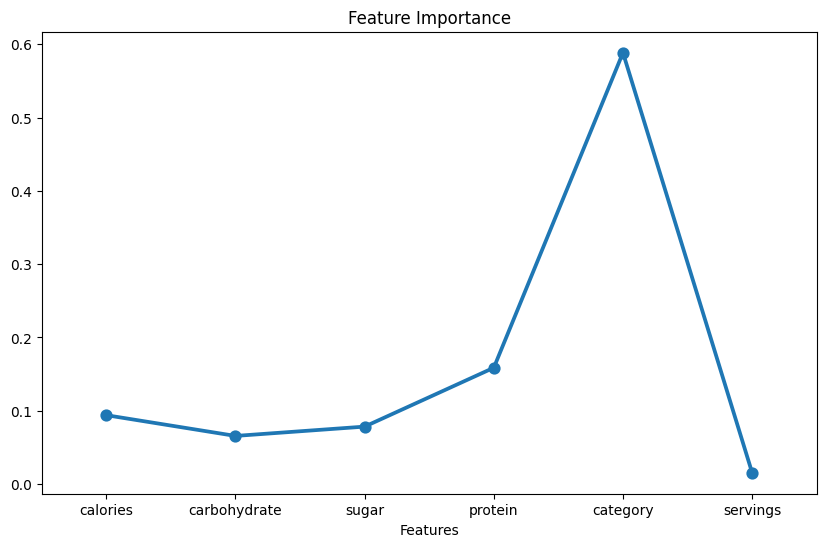

In [49]:
plt.figure(figsize=(10,6))
sns.pointplot(y=tuned_forest.feature_importances_,x=X_train.columns)
plt.xlabel("Features")
plt.title("Feature Importance")

#### I also recommend some other important measures that Tasty Bytes should undertake : <br>-Collect more data and create more features such us the time it takes for preparation and the cost of the recipe. <br> -Continuously monitor the performance of the model against its KPI so that we can always have the best possible predictions. <br>-Fully Deploy the RandomForestClassifier and work on its UI/UX to ensure the best experience for its users.  